<a href="https://colab.research.google.com/github/swastika2108/sanskritmorphologicalanalyser/blob/main/Seq2SeqRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/Datasets

[Errno 2] No such file or directory: 'drive/MyDrive/Datasets'
/content/drive/MyDrive/Datasets


In [ ]:

import numpy as np
import torch
import torch.nn as nn
import unicodedata
import os
import json
import io
import copy
from devconvert import dev2slp, iast2slp, slp2dev, slp2iast, slp2tex, slp2wx, wx2slp, dev2wx

# #: Symbol that shows starting of decoding input     #
# $: Symbol that shows starting of decoding output    $
# @: Symbol that will fill in blank sequence if current batch data size is short than time steps      @

In [ ]:
def make_batch():
    input_batch, output_batch, target_batch = [], [], []

    for seq in seq_data:
        for i in range(2):
            #seq[i] = seq[i] + 'P' * (n_step - len(seq[i]))
            seq[i] = seq[i] + '@' * (n_step - len(seq[i]))

        input = [num_dic[n] for n in seq[0]]
        output = [num_dic[n] for n in ('#' + seq[1])]
        target = [num_dic[n] for n in (seq[1] + '$')]

        input_batch.append(np.eye(n_class)[input])
        output_batch.append(np.eye(n_class)[output])
        target_batch.append(target) # not one-hot

    # make tensor
    return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)

In [ ]:
# make test batch
def make_testbatch(input_word):
    input_batch, output_batch = [], []

    #input_w = input_word + 'P' * (n_step - len(input_word))
    input_w = input_word + '@' * (n_step - len(input_word))
    input = [num_dic[n] for n in input_w]
    #output = [num_dic[n] for n in 'S' + 'P' * n_step]
    output = [num_dic[n] for n in '#' + '@' * n_step]

    input_batch = np.eye(n_class)[input]
    output_batch = np.eye(n_class)[output]

    return torch.FloatTensor(input_batch).unsqueeze(0), torch.FloatTensor(output_batch).unsqueeze(0)

In [ ]:
# Model
class Seq2Seq(nn.Module):
    def __init__(self):
        super(Seq2Seq, self).__init__()

        self.enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.2,num_layers=3)
        self.dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.2,num_layers=3)
        self.fc = nn.Linear(n_hidden, n_class)

    def forward(self, enc_input, enc_hidden, dec_input):
        enc_input = enc_input.transpose(0, 1) # enc_input: [max_len(=n_step, time step), batch_size, n_class]
        dec_input = dec_input.transpose(0, 1) # dec_input: [max_len(=n_step, time step), batch_size, n_class]

        # enc_states : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        _, enc_states = self.enc_cell(enc_input, enc_hidden)
        # outputs : [max_len+1(=6), batch_size, num_directions(=1) * n_hidden(=128)]
        outputs, _ = self.dec_cell(dec_input, enc_states)

        model = self.fc(outputs) # model : [max_len+1(=6), batch_size, n_class]
        return model

In [ ]:
"""
Preprocessing of the data
"""


def normalize_and_iast2wx(text):
    """
    The final normalization followed by transliteration according to the requirement and convenience. Here we use WX to make it look simple.
    Input: String -> word
    Output: String -> Unicode string normalized with NFC and transliterated to WX
    """
    return (slp2wx.convert(iast2slp.convert(unicodedata.normalize('NFC', text))))

def wx2iast(text):
    """
    Converts the notation from wx to iast
    Input: String -> in wx notation
    Output: String -> in iast notation
    """
    return (slp2iast.convert(wx2slp.convert(text)))

def unicode_normalize(dict_item):
    """
    It is recommended to use unicode normalization for the sanskrit strings to avoid potential normalization mismatches.
    Input:  Dict -> JSON object for a DCS sentence, an element from JSON List
    Output: Dict -> Same content as the input, but all the unicode strings normalized with NFC
    """
    dict_item["joint_sentence"] = normalize_and_iast2wx(dict_item["joint_sentence"]) #joint sentence - input for tasks 1 and 3
    dict_item["segmented_sentence"] = (dict_item["segmented_sentence"])  #segmented sentence - input for task 2
    dict_item["t1_ground_truth"] = [[normalize_and_iast2wx(x) for x in inner] for inner in dict_item["t1_ground_truth"]]   #ground truth for task 1 - word segmentation
    dict_item["t2_ground_truth"] = [[normalize_and_iast2wx(inner[0]), inner[1]] for inner in dict_item["t2_ground_truth"]] #ground truth for task 2 - morphological parsing
    dict_item["t3_ground_truth"] = [[[normalize_and_iast2wx(x[0]), normalize_and_iast2wx(x[1]), x[2]] for x in inner] for inner in dict_item["t3_ground_truth"] ]   #ground truth for task 3 - word segmentation and morphological parsing

    return dict_item


def get_data(data):
    """
    Returns the unicode normalised data from the given data
    Input: Data list
    Output: List of dictionary items
    """
    normalised_data = list()
    for item in data: #iterate over the list of json data to operate on the values

        dict_item = unicode_normalize(item) # It is recommended to use unicode normalization
                                            # for the sanskrit strings to avoid potential normalization mismatches
        normalised_data.append(dict_item)   # List containing all the entries in the json file, but after normalization

    return normalised_data


def get_task1_IO(json_entry):
    """
    Returns the input (as a string) and the groundtruth (as a list of segmented words) for the task 1: Word segmentation.
    Input: json object -> Json object for a DCS sentence
    Output: tuple(String, List) -> A tuple of the sentence (words joined with sandhi) and a flattened list of segmented words
    """
    flattened_list = [val for sublist in json_entry['t1_ground_truth'] for val in sublist] # Flatten the nested list to a
                                                                                           # single linear list

    return (json_entry["joint_sentence"], " ".join(flattened_list))


def createTaskDict(jsonData,taskName="t1"):
    """
    Create a dictionary containing the input and groundtruth for each task. The keys for the dictioanry are the sentence Ids.
    Input: Json Dictionary and task name - {t1, t2, t3}
    Output: Dictionary containing the task input and ground truth
    """
    task_Dict = dict()

    if taskName == "t1":
        for item in jsonData: # Get the input and ground truth for all the entries in the normalised_data
            task_Dict[item["sent_id"]] = get_task1_IO(item)

    return task_Dict


def get_tasks_data_IO(normalised_data, task):
    """
    Returns the data in the form of (X, y) where X is the input list and y is the expected results list
    Input: Normalised data and task
    Output: Data list and test list depending on the task provided
    """
    taskDict = createTaskDict(normalised_data,task)

#     X = [taskDict.get(key)[0] for key in taskDict.keys()]
#     y = [taskDict.get(key)[1] for key in taskDict.keys()]

    data_IO = [[taskDict.get(key)[0], taskDict.get(key)[1]] for key in taskDict.keys()]

    return data_IO

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
with open('wsmp_train.json', encoding='utf-8') as data_file: #open the json list file
    data = json.load(data_file)    # this is a list of json entities each having the inputs and ground truths for the three tasks
    normalised_training_data = get_data(data) # list of dictionary items from the training set

with open('wsmp_dev.json', encoding='utf-8') as data_file: #open the json list file
    data = json.load(data_file)    # this is a list of json entities each having the inputs and ground truths for the three tasks
    normalised_dev_data = get_data(data) # list of dictionary items from the development set

In [ ]:
if __name__ == '__main__':
    n_step = 63
#     n_step = 216


    char_arr = [c for c in '#$@abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ ']
    num_dic = {n: i for i, n in enumerate(char_arr)}
#     seq_data = [['Bavawi cAwra', 'Bavawi ca awra'], ['BavawaS cAwra', 'BavawaH ca awra'], ['yaWovAca BagavAn XanvanwariH', 'yaWA uvAca BagavAn XanvanwariH'], ['vAwakqcCIwalam loham wqRNApiwwakaPApaham', 'vAwa kqw SIwalam loham wqRNA piwwa kaPa apaham'], ['anupAnam vaxanwyeke wEle yURAmlakAFjikam', 'anupAnam vaxanwi eke wEle yURa amla kAFjikam'], ['agnir uvAca', 'agniH uvAca'], ['vAsukir uvAca', 'vAsukiH uvAca'], ['brahmovAca', 'brahmA uvAca'], ['waWEva nAgarA rAjaF SiSyire brAhmaNAxayaH', 'waWA eva nAgarAH rAjan SiSyire brAhmaNa AxayaH'], ['wawaswu Sayane xivye nAgaxawwe mahABujaH', 'wawaH wu Sayane xivye nAga xawwe mahA BujaH']]

    train_data_IO = get_tasks_data_IO(normalised_training_data, "t1") # get the training pairs
    dev_data_IO = get_tasks_data_IO(normalised_dev_data, "t1") # get the dev pairs

    print(train_data_IO[0])
    seq_data = train_data_IO[:4]

    n_class = len(num_dic)
    n_hidden = 128
    model = Seq2Seq().to(device)

    criterion = nn.CrossEntropyLoss()


['GatasWayogam yogeSa wawwvajFAnasya kAraNam', 'Gata sWa yogam yoga ISa wawwva jFAnasya kAraNam']


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-5)


In [ ]:
input_batch, output_batch, target_batch = make_batch()
input_batch, output_batch, target_batch =  input_batch.to(device), output_batch.to(device), target_batch.to(device)
batch_size = len(seq_data)


In [ ]:
import matplotlib.pyplot as plt

def plot_loss(loss_fun):
    epochs, losses = zip(*loss_fun)
    plt.plot(epochs, losses, label='Training Loss')
    plt.title('Loss as a function of Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

loss_fn = []

In [ ]:
    for epoch in range(300000):
        # make hidden shape [num_layers * num_directions, batch_size, n_hidden]
        hidden = torch.zeros(3, batch_size, n_hidden).to(device)

        optimizer.zero_grad()
        # input_batch : [batch_size, max_len(=n_step, time step), n_class]
        # output_batch : [batch_size, max_len+1(=n_step, time step) (becase of 'S' or 'E'), n_class]
        # target_batch : [batch_size, max_len+1(=n_step, time step)], not one-hot
        output = model(input_batch, hidden, output_batch)

        # output : [max_len+1, batch_size, n_class]
        output = output.transpose(0, 1) # [batch_size, max_len+1(=6), n_class]
        loss = 0
        for i in range(0, len(target_batch)):
            # output[i] : [max_len+1, n_class, target_batch[i] : max_len+1]
            loss += criterion(output[i], target_batch[i])
        if (epoch + 1) % 10000 == 0:

            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
            loss_fn.append((epoch+1,loss.cpu().item()
))

        loss.backward()
        optimizer.step()

Epoch: 10000 cost = 0.051060
Epoch: 20000 cost = 0.086868
Epoch: 30000 cost = 0.086398
Epoch: 40000 cost = 0.086899
Epoch: 50000 cost = 0.048226
Epoch: 60000 cost = 0.085767


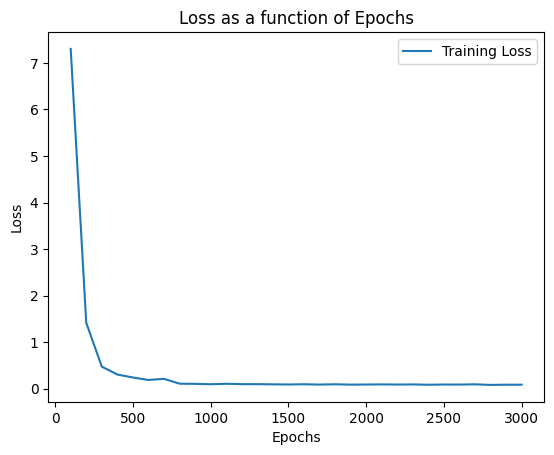

In [ ]:
plot_loss(loss_fn)

In [ ]:
    # Test
    def translate(word):
        input_batch, output_batch = make_testbatch(word)
        input_batch, output_batch = input_batch.to(device), output_batch.to(device)

        # make hidden shape [num_layers * num_directions, batch_size, n_hidden]
        hidden = torch.zeros(3, 1, n_hidden).to(device)
        output = model(input_batch, hidden, output_batch)
        # output : [max_len+1(=6), batch_size(=1), n_class]

        predict = output.data.max(2, keepdim=True)[1] # select n_class dimension
        #print(predict)
        decoded = [char_arr[i] for i in predict]

        #end = decoded.index('E')
        print(decoded)
        translated = ''.join(decoded)

        #return translated.replace('P', '')
        return translated.replace('@', '')

    print('test')
    print('First ->', translate("Gataswa"))

test
['G', 'a', 't', 'a', ' ', ' ', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '$', '@', '@']
First -> Gata  $
